In [24]:
# %pip install cartopy
# %pip install git+https://bitbucket.org/jsteven5/tasplot.git

In [25]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches


plt.rcParams['font.family'] = 'Arial'
plt.rcParams["pdf.fonttype"]=42
plt.rcParams["font.size"] =12
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'


In [26]:
volcanodata = pd.read_excel("S3_MI_compilation_XH2O_revised.xlsx", sheet_name="XH2O_calculated")

SiO2_min = 30
SiO2_max = 57

vdatafilt = volcanodata[(volcanodata['SaturationP_bars_VESIcal'] != 0)&(volcanodata['SiO2'].between(SiO2_min, SiO2_max))&~(volcanodata['MgO']>16)]

vdatafilt.to_clipboard(excel=True,index=False)

In [27]:
vdatafilt2 = vdatafilt.sort_values(by=['Location type','Location','Volcano']).copy()

aggregated_df = pd.DataFrame()

grouped = vdatafilt2.groupby('Volcano')

# Iterate over columns
for col in vdatafilt2.columns:
    if pd.api.types.is_numeric_dtype(vdatafilt2[col]):
        # For numeric columns, calculate median only if there is more than one row in the group
        aggregated_df[col] = grouped[col].median() if len(grouped[col]) > 1 else grouped[col].first()
    else:
        # For string columns, preserve the first occurrence
        aggregated_df[col] = grouped[col].first()

aggregated_df = aggregated_df.reset_index(drop=True)
aggregated_df.head()

pd.DataFrame(aggregated_df.to_clipboard(excel=True,index=False))

""


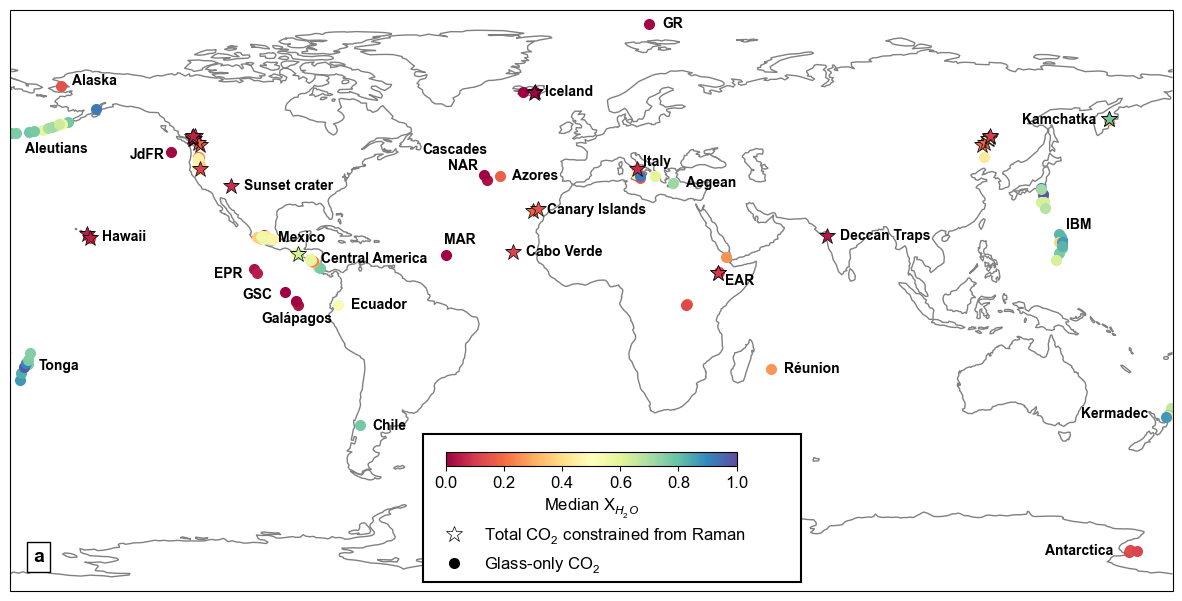

In [28]:
xh2o=aggregated_df.copy()
xh2o=xh2o[xh2o['SaturationP_bars_VESIcal']/10>20]
bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

# Sample dataframe of volcanoes
data = {
    'Volcano': xh2o['Volcano'],
    'Latitude': xh2o['Latitude'],
    'Longitude': xh2o['Longitude'],
    'XH2O': xh2o['XH2O_fl_VESIcal'],
    'Raman_Homog': xh2o['Raman/Homog'],  # Assuming you have this column
    'Location': xh2o['Location']  # Assuming you have a column for location
}

df = pd.DataFrame(data)

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines(color='grey')

# Plot markers with NaN values in 'Raman_Homog' column as circles
for index, row in df[df['Raman_Homog'].isnull()].iterrows():
    ax.plot(row['Longitude'], row['Latitude'], 'o', markersize=7, transform=ccrs.PlateCarree(),
            color=plt.cm.Spectral(row['XH2O']))

# Plot markers with non-NaN values in 'Raman_Homog' column as stars
for index, row in df.dropna(subset=['Raman_Homog']).iterrows():
    ax.plot(row['Longitude'], row['Latitude'], '*', markersize=12, transform=ccrs.PlateCarree(),
            color='none', markerfacecolor=plt.cm.Spectral(row['XH2O']), markeredgewidth=0.5, markeredgecolor='black')

for location in df['Location'].unique():
    loc_df = df[df['Location'] == location]
    avg_lat = loc_df['Latitude'].mean()
    avg_lon = loc_df['Longitude'].mean()
    if location in ['Kamchatka','Kermadec','Antarctica']:
        ax.text(avg_lon - 27, avg_lat, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location == 'MAR':
        ax.text(avg_lon - 7, avg_lat-7, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location == 'NAR':
        ax.text(avg_lon - 11, avg_lat+3, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location == 'Galápagos':
        ax.text(avg_lon - 11, avg_lat-5, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location == 'Alaska':
        ax.text(avg_lon - 20, avg_lat+13, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location == 'Aleutians':
        ax.text(avg_lon - 9, avg_lat-7, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location == 'EAR':
        ax.text(avg_lon +5, avg_lat, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location == 'Italy':
        ax.text(avg_lon +1, avg_lat+4, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    elif location in ['GSC','EPR','JdFR']:
        ax.text(avg_lon - 13, avg_lat-1, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')
    else:
        ax.text(avg_lon + 4, avg_lat, location, transform=ccrs.PlateCarree(),
                fontsize=10, fontweight='bold', va='center', color='black')

sm = plt.cm.ScalarMappable(cmap='Spectral')
sm.set_array([])
cbar_label = 'Median X$_{H_2O}$'
# Create inset axes for the colorbar and legend
cax = inset_axes(ax, width="50%", height="60%", loc='lower center', bbox_to_anchor=(0.25, 0.2, 0.5, 0.04), bbox_transform=ax.transAxes)
# Create colorbar
cbar = plt.colorbar(sm, cax=cax, label=cbar_label, orientation='horizontal')
# Create legend
legend_handles = []
legend_labels = []

dummycircle = ax.plot([], [], 'o', markersize=7, color='k', label='Glass-only CO$_2$')
dummystar = ax.plot([], [], '*', markersize=12, color='white', markeredgewidth=0.5, markeredgecolor='k',
                    label='Total CO$_2$ constrained from Raman')

legend_handles.extend([dummystar[0], dummycircle[0]])
legend_labels.extend([dummystar[0].get_label(), dummycircle[0].get_label()])

# Draw bounding box around colorbar and legend
bbox = dict(boxstyle='square', facecolor='white', edgecolor='black')
ax.text(0.02,0.05, 'a', fontsize=14, fontweight='bold', bbox=bbox,transform=ax.transAxes)

# Create a FancyBboxPatch for the bounding box enclosing colorbar and legend
rect = FancyBboxPatch((0.22,-8), 0.7, 10, boxstyle="square,pad=0.3", linewidth=1.5, facecolor="white", edgecolor="black", transform=cax.transAxes,zorder=3)
ax.add_patch(rect)

# Add legend
ax.legend(legend_handles, legend_labels, loc='lower center', frameon=False)

plt.show()

fig.savefig("map_panel.pdf")


## Filtered considering P> 20 MPa

/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4208/3536051327.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes1=axs[0].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4208/3536051327.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes2=axs[1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4208/3536051327.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes3 = axs[1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=Fal

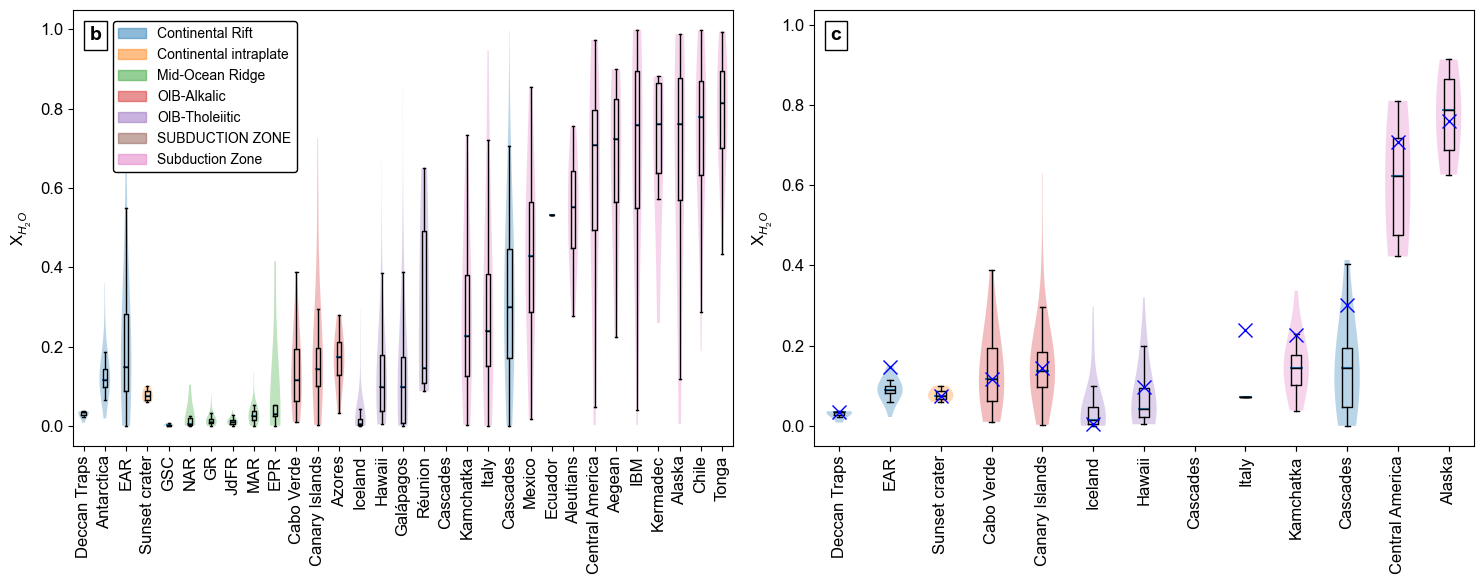

In [29]:
data_filtered_P_over20=vdatafilt2[vdatafilt2['SaturationP_bars_VESIcal']/10>20]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

# Define color dictionary
color_dict = {}

boxplot_data = []
labels = []
location_types = data_filtered_P_over20['Location type'].unique()

for i, loc_type in enumerate(location_types):
    loc_data = data_filtered_P_over20[data_filtered_P_over20['Location type'] == loc_type]
    loc_labels = loc_data.groupby('Location')['XH2O_fl_VESIcal'].median().sort_values().index
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['XH2O_fl_VESIcal'].values for loc in loc_labels])

    # Assign colors based on index (same as in the first panel)
    color_dict[loc_type] = plt.get_cmap('tab10')(i)

# Plotting the first panel
violins1 = axs[0].violinplot(boxplot_data, showmeans=False, showextrema=False, showmedians=True, bw_method=1)

for i, loc_type in enumerate(location_types):
    loc_indices = data_filtered_P_over20[data_filtered_P_over20['Location type'] == loc_type]['Location']
    violin_indices = [labels.index(loc) for loc in loc_indices]
    for violin_index in violin_indices:
        violins1['bodies'][violin_index].set_facecolor(color_dict[loc_type])  

boxes1=axs[0].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
axs[0].set_xticklabels(labels, rotation=90)

## Plot violin color legend ##
legend_handles = []
legend_labels = []
for loc_type, color in color_dict.items():
    legend_handles.append(mpatches.Patch(color=color, alpha=0.5, label=loc_type))
    legend_labels.append(loc_type)

axs[0].legend(handles=legend_handles, labels=legend_labels, loc='upper left',bbox_to_anchor=(0.05, 0.99),framealpha=1, edgecolor='black',fontsize=10)

vdatafilt3=data_filtered_P_over20.copy()
vdatafilt3.dropna(subset=['Raman/Homog'], inplace=True)

# Plotting the second panel
boxplot_data = []
labels = []
location_types = vdatafilt3['Location type'].unique()

for loc_type in location_types:
    loc_data = vdatafilt3[vdatafilt3['Location type'] == loc_type]
    loc_labels = loc_data.groupby('Location')['XH2O_fl_VESIcal'].median().sort_values().index
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['XH2O_fl_VESIcal'].values for loc in loc_labels])

violins2 = axs[1].violinplot(boxplot_data, showmeans=False, showextrema=False, showmedians=True, bw_method=1)

for loc_type in location_types:
    loc_indices = vdatafilt3[vdatafilt3['Location type'] == loc_type]['Location']
    violin_indices = [labels.index(loc) for loc in loc_indices]
    for violin_index in violin_indices:
        violins2['bodies'][violin_index].set_facecolor(color_dict[loc_type])

boxes2=axs[1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
axs[1].set_xticklabels(labels, rotation=90)



# Add the plotting of medians
vdatafilt4 = data_filtered_P_over20.copy()
vdatafilt4 = vdatafilt4[vdatafilt4['Location'].isin(vdatafilt3['Location'].unique())]

boxplot_data = []
labels = []
location_types = vdatafilt4['Location type'].unique()

# Calculate and sort medians from vdatafilt3
median_order = vdatafilt3.groupby('Location')['XH2O_fl_VESIcal'].median().sort_values().index

for loc_type in location_types:
    loc_data = vdatafilt4[vdatafilt4['Location type'] == loc_type]
    # Use the median order from vdatafilt3 to sort labels and data
    loc_labels = [loc for loc in median_order if loc in loc_data['Location'].unique()]
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['XH2O_fl_VESIcal'].values for loc in loc_labels])

# Plotting
boxes3 = axs[1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)

# Adjust boxplot appearance
for whisker in boxes3['whiskers']:
    whisker.set_visible(False)

for cap in boxes3['caps']:
    cap.set_visible(False)

for cap in boxes3['boxes']:
    cap.set_visible(False)

for median in boxes3['medians']:
    median.set_color('blue')
    x = np.mean(median.get_xdata())
    y = np.mean(median.get_ydata())
    median.set_marker('x')
    median.set_markersize(10)
    median.set_xdata([x])
    median.set_ydata([y])

for median in boxes1['medians']:
    median.set_color('k')
for median in boxes2['medians']:
    median.set_color('k')

    
pos=(0.025,0.93)

axs[0].text(pos[0], pos[1], 'b', transform=axs[0].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[1].text(pos[0], pos[1], 'c', transform=axs[1].transAxes, fontsize=14, fontweight='bold', bbox=bbox)

axs[0].set_ylabel('X$_{H_2O}$')
axs[1].set_ylabel('X$_{H_2O}$')
# Additional modifications
fig.tight_layout()


fig.savefig("violin_panels_XH2O.pdf")
plt.show()


## Supplement plots

/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4208/1046964893.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes1=axs[0,0].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4208/1046964893.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes2=axs[0,1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
/var/folders/r2/dcn33vbj1x1b46n5mm7vn9bc0000gn/T/ipykernel_4208/1046964893.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes3 = axs[0,1].boxplot(boxplot_data, labels=labels, widths=0.2, showflie

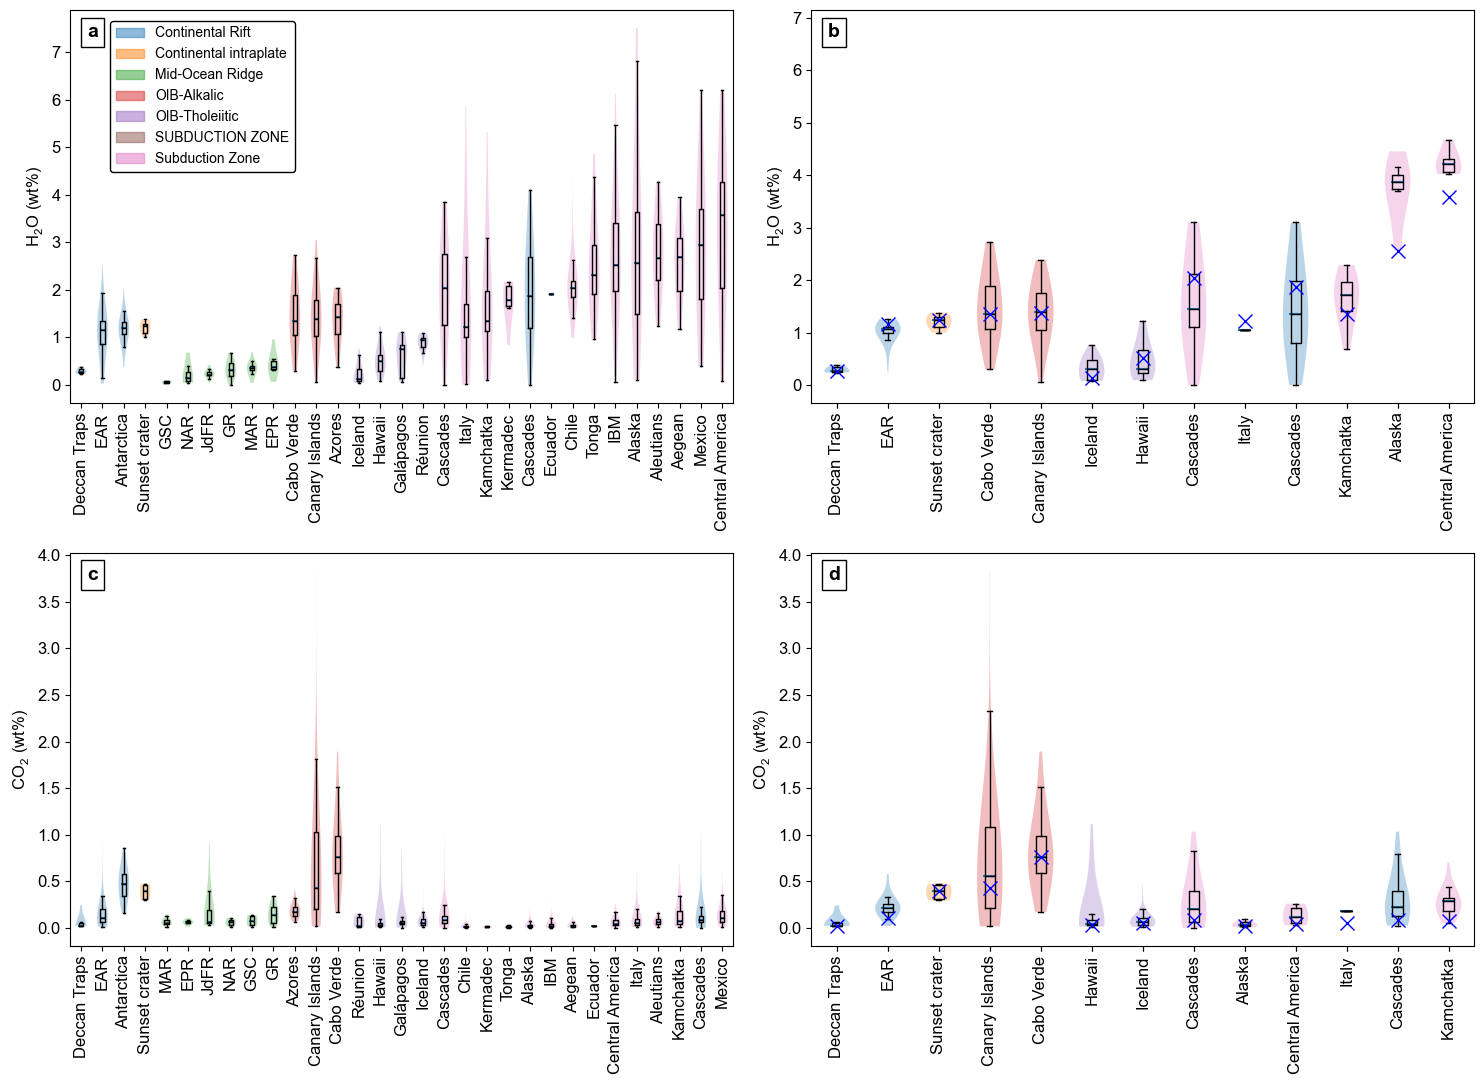

In [30]:

fig, axs = plt.subplots(2, 2, figsize=(15, 11))

# Define color dictionary
color_dict = {}

boxplot_data = []
labels = []
location_types = data_filtered_P_over20['Location type'].unique()

for i, loc_type in enumerate(location_types):
    loc_data = data_filtered_P_over20[data_filtered_P_over20['Location type'] == loc_type]
    loc_labels = loc_data.groupby('Location')['H2O'].median().sort_values().index
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['H2O'].values for loc in loc_labels])

    # Assign colors based on index (same as in the first panel)
    color_dict[loc_type] = plt.get_cmap('tab10')(i)

# Plotting the first panel
violins1 = axs[0,0].violinplot(boxplot_data, showmeans=False, showextrema=False, showmedians=True, bw_method=1)

for i, loc_type in enumerate(location_types):
    loc_indices = data_filtered_P_over20[data_filtered_P_over20['Location type'] == loc_type]['Location']
    violin_indices = [labels.index(loc) for loc in loc_indices]
    for violin_index in violin_indices:
        violins1['bodies'][violin_index].set_facecolor(color_dict[loc_type])  

boxes1=axs[0,0].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
axs[0,0].set_xticklabels(labels, rotation=90)

## Plot violin color legend ##
legend_handles = []
legend_labels = []
for loc_type, color in color_dict.items():
    legend_handles.append(mpatches.Patch(color=color, alpha=0.5, label=loc_type))
    legend_labels.append(loc_type)

axs[0,0].legend(handles=legend_handles, labels=legend_labels, loc='upper left',bbox_to_anchor=(0.05, 0.99),framealpha=1, edgecolor='black',fontsize=10)

############### Plotting the second panel with the Raman only ###################
vdatafilt3=data_filtered_P_over20.copy()
vdatafilt3.dropna(subset=['Raman/Homog'], inplace=True)

boxplot_data = []
labels = []
location_types = vdatafilt3['Location type'].unique()

for loc_type in location_types:
    loc_data = vdatafilt3[vdatafilt3['Location type'] == loc_type]
    loc_labels = loc_data.groupby('Location')['H2O'].median().sort_values().index
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['H2O'].values for loc in loc_labels])

violins2 = axs[0,1].violinplot(boxplot_data, showmeans=False, showextrema=False, showmedians=True, bw_method=1)

for loc_type in location_types:
    loc_indices = vdatafilt3[vdatafilt3['Location type'] == loc_type]['Location']
    violin_indices = [labels.index(loc) for loc in loc_indices]
    for violin_index in violin_indices:
        violins2['bodies'][violin_index].set_facecolor(color_dict[loc_type])

boxes2=axs[0,1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
axs[0,1].set_xticklabels(labels, rotation=90)

# Add the plotting of medians
vdatafilt4 = data_filtered_P_over20.copy()
vdatafilt4 = vdatafilt4[vdatafilt4['Location'].isin(vdatafilt3['Location'].unique())]

boxplot_data = []
labels = []
location_types = vdatafilt4['Location type'].unique()

# Calculate and sort medians from vdatafilt3
median_order = vdatafilt3.groupby('Location')['H2O'].median().sort_values().index

for loc_type in location_types:
    loc_data = vdatafilt4[vdatafilt4['Location type'] == loc_type]
    # Use the median order from vdatafilt3 to sort labels and data
    loc_labels = [loc for loc in median_order if loc in loc_data['Location'].unique()]
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['H2O'].values for loc in loc_labels])

# Plotting
boxes3 = axs[0,1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)

# Adjust boxplot appearance
for whisker in boxes3['whiskers']:
    whisker.set_visible(False)

for cap in boxes3['caps']:
    cap.set_visible(False)

for cap in boxes3['boxes']:
    cap.set_visible(False)

for median in boxes3['medians']:
    median.set_color('blue')
    x = np.mean(median.get_xdata())
    y = np.mean(median.get_ydata())
    median.set_marker('x')
    median.set_markersize(10)
    median.set_xdata([x])
    median.set_ydata([y])

for median in boxes1['medians']:
    median.set_color('k')
for median in boxes2['medians']:
    median.set_color('k')

##################### CO2 PANELS ###############################

# Define color dictionary
color_dict = {}

boxplot_data = []
labels = []
location_types = data_filtered_P_over20['Location type'].unique()

for i, loc_type in enumerate(location_types):
    loc_data = data_filtered_P_over20[data_filtered_P_over20['Location type'] == loc_type]
    loc_labels = loc_data.groupby('Location')['CO2'].median().sort_values().index
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['CO2'].values for loc in loc_labels])

    # Assign colors based on index (same as in the first panel)
    color_dict[loc_type] = plt.get_cmap('tab10')(i)

# Plotting the first panel
violins1 = axs[1,0].violinplot(boxplot_data, showmeans=False, showextrema=False, showmedians=True, bw_method=1)

for i, loc_type in enumerate(location_types):
    loc_indices = data_filtered_P_over20[data_filtered_P_over20['Location type'] == loc_type]['Location']
    violin_indices = [labels.index(loc) for loc in loc_indices]
    for violin_index in violin_indices:
        violins1['bodies'][violin_index].set_facecolor(color_dict[loc_type])  

boxes1=axs[1,0].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
axs[1,0].set_xticklabels(labels, rotation=90)


vdatafilt3=data_filtered_P_over20.copy()
vdatafilt3.dropna(subset=['Raman/Homog'], inplace=True)

# Plotting the second panel
boxplot_data = []
labels = []
location_types = vdatafilt3['Location type'].unique()

for loc_type in location_types:
    loc_data = vdatafilt3[vdatafilt3['Location type'] == loc_type]
    loc_labels = loc_data.groupby('Location')['CO2'].median().sort_values().index
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['CO2'].values for loc in loc_labels])

violins2 = axs[1,1].violinplot(boxplot_data, showmeans=False, showextrema=False, showmedians=True, bw_method=1)

for loc_type in location_types:
    loc_indices = vdatafilt3[vdatafilt3['Location type'] == loc_type]['Location']
    violin_indices = [labels.index(loc) for loc in loc_indices]
    for violin_index in violin_indices:
        violins2['bodies'][violin_index].set_facecolor(color_dict[loc_type])

boxes2=axs[1,1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)
axs[1,1].set_xticklabels(labels, rotation=90)

# Add the plotting of medians
vdatafilt4 = data_filtered_P_over20.copy()
vdatafilt4 = vdatafilt4[vdatafilt4['Location'].isin(vdatafilt3['Location'].unique())]

boxplot_data = []
labels = []
location_types = vdatafilt4['Location type'].unique()

# Calculate and sort medians from vdatafilt3
median_order = vdatafilt3.groupby('Location')['CO2'].median().sort_values().index

for loc_type in location_types:
    loc_data = vdatafilt4[vdatafilt4['Location type'] == loc_type]
    # Use the median order from vdatafilt3 to sort labels and data
    loc_labels = [loc for loc in median_order if loc in loc_data['Location'].unique()]
    labels.extend(loc_labels)
    boxplot_data.extend([loc_data[loc_data['Location'] == loc]['CO2'].values for loc in loc_labels])

# Plotting
boxes3 = axs[1,1].boxplot(boxplot_data, labels=labels, widths=0.2, showfliers=False)

# Adjust boxplot appearance
for whisker in boxes3['whiskers']:
    whisker.set_visible(False)

for cap in boxes3['caps']:
    cap.set_visible(False)

for cap in boxes3['boxes']:
    cap.set_visible(False)

for median in boxes3['medians']:
    median.set_color('blue')
    x = np.mean(median.get_xdata())
    y = np.mean(median.get_ydata())
    median.set_marker('x')
    median.set_markersize(10)
    median.set_xdata([x])
    median.set_ydata([y])

for median in boxes1['medians']:
    median.set_color('k')
for median in boxes2['medians']:
    median.set_color('k')



pos=(0.025,0.93)

axs[0,0].text(pos[0], pos[1], 'a', transform=axs[0,0].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[0,1].text(pos[0], pos[1], 'b', transform=axs[0,1].transAxes, fontsize=14, fontweight='bold', bbox=bbox)

axs[1,0].text(pos[0], pos[1], 'c', transform=axs[1,0].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[1,1].text(pos[0], pos[1], 'd', transform=axs[1,1].transAxes, fontsize=14, fontweight='bold', bbox=bbox)


axs[0,0].set_ylabel('H$_2$O (wt%)')
axs[0,1].set_ylabel('H$_2$O (wt%)')

axs[1,0].set_ylabel('CO$_2$ (wt%)')
axs[1,1].set_ylabel('CO$_2$ (wt%)')


# Additional modifications
fig.tight_layout()

fig.savefig("FigS_violin_panels_H2Owt%.pdf")

plt.show()


## TAS plotting

In [31]:
# Create DataFrame
Irvine_Baragar_1971_TAS_alk_subalk = pd.DataFrame([
    (45.3467312706644, 2.90479178360426),
    (46.08412131106158, 3.2478236783792322),
    (46.662298258824386, 3.4784357608967493),
    (47.50509069504223, 3.8123796122874456),
    (48.497238752868284, 4.170176595920335),
    (49.862775864714905, 4.635312674643091),
    (50.92960173334508, 4.987146375215432),
    (52.44982859614308, 5.51787856760422),
    (54.68482879092329, 6.316958497717669),
    (56.46642799153568, 6.943103219075225),
    (59.43220390632757, 7.804797621324433),
    (62.48332589060987, 8.654565457452545),
    (65.139722303499, 9.388049273899968),
    (66.942658021484, 9.888965050986013)
], columns=['SiO2 (wt%)', 'Total Alkali (wt%)'])

Miyashiro_1974_TAS_alk_subalk = pd.DataFrame([
    (38.48488773747841, 0.08565896431569797),
    (40.517846862406444, 1.0423381368274391),
    (41.30044617156016, 1.3951079063023606),
    (42.83865860679332, 2.0856985099598013),
    (43.6482440990213, 2.4294914802070977),
    (45.258419689119165, 3.1469861384459534),
    (46.85959988485895, 3.762797974568805),
    (46.05001439263097, 3.457884322916591),
    (48.43379389752447, 4.360670158584231),
    (49.33333333333333, 4.653605447034375),
    (51.393278641335634, 5.34709689104295),
    (50.736614853195164, 5.149822701629478),
    (53.16537132987911, 5.968860718505923),
    (52.38277202072539, 5.6998310198511675),
    (54.32577720207254, 6.381379741324379),
    (55.98992515831894, 6.889514924947575),
    (57.762017846862406, 7.403612947070323),
    (56.74553828439839, 7.1166792369748535),
    (58.661557282671275, 7.642715332850356),
    (59.570092112838225, 7.857890434516131),
    (60.262737478411054, 7.995344089252658),
    (61.10830454807139, 8.150715701777743),
    (62.06181635002879, 8.294105851912347),
    (63.02432354634427, 8.407587284302684),
    (63.941853770869315, 8.50911359740402),
    (64.9853195164076, 8.61061821618649),
    (65.90284974093265, 8.694200228397786),
    (66.90133851468049, 8.795712595151283),
    (67.764896373057, 8.90921107307787),
    (68.71840817501439, 9.028675488692423),
    (70.32858376511227, 9.189896819340126),
    (72.31656591824986, 9.386941668811303),
    (73.36902705814623, 9.470500437109532),
    (75.33002302820957, 9.658577784918304),
    (76.29253022452505, 9.77504993412365),
    (76.94919401266552, 9.846714017306857),
    (74.32253886010363, 9.548094817314),
    (75.83376511226253, 9.715314627127961),
    (71.30908175014393, 9.297393718912039),
    (69.42004893494531, 9.106313257534621),
    (55.03641335636154, 6.602570367692671),
    (47.36334196891192, 3.954117073453741),
    (44.196963154864704, 2.6925800346811606),
    (41.87615141047783, 1.652210378363801),
    (39.51036269430051, 0.5639970009773627)
], columns=['SiO2 (wt%)', 'Total Alkali (wt%)'])


Miya_Pf = np.poly1d(np.polyfit(Miyashiro_1974_TAS_alk_subalk['SiO2 (wt%)'],Miyashiro_1974_TAS_alk_subalk['Total Alkali (wt%)'], 8))
IB_Pf = np.poly1d(np.polyfit(Irvine_Baragar_1971_TAS_alk_subalk['SiO2 (wt%)'],Irvine_Baragar_1971_TAS_alk_subalk['Total Alkali (wt%)'],3))


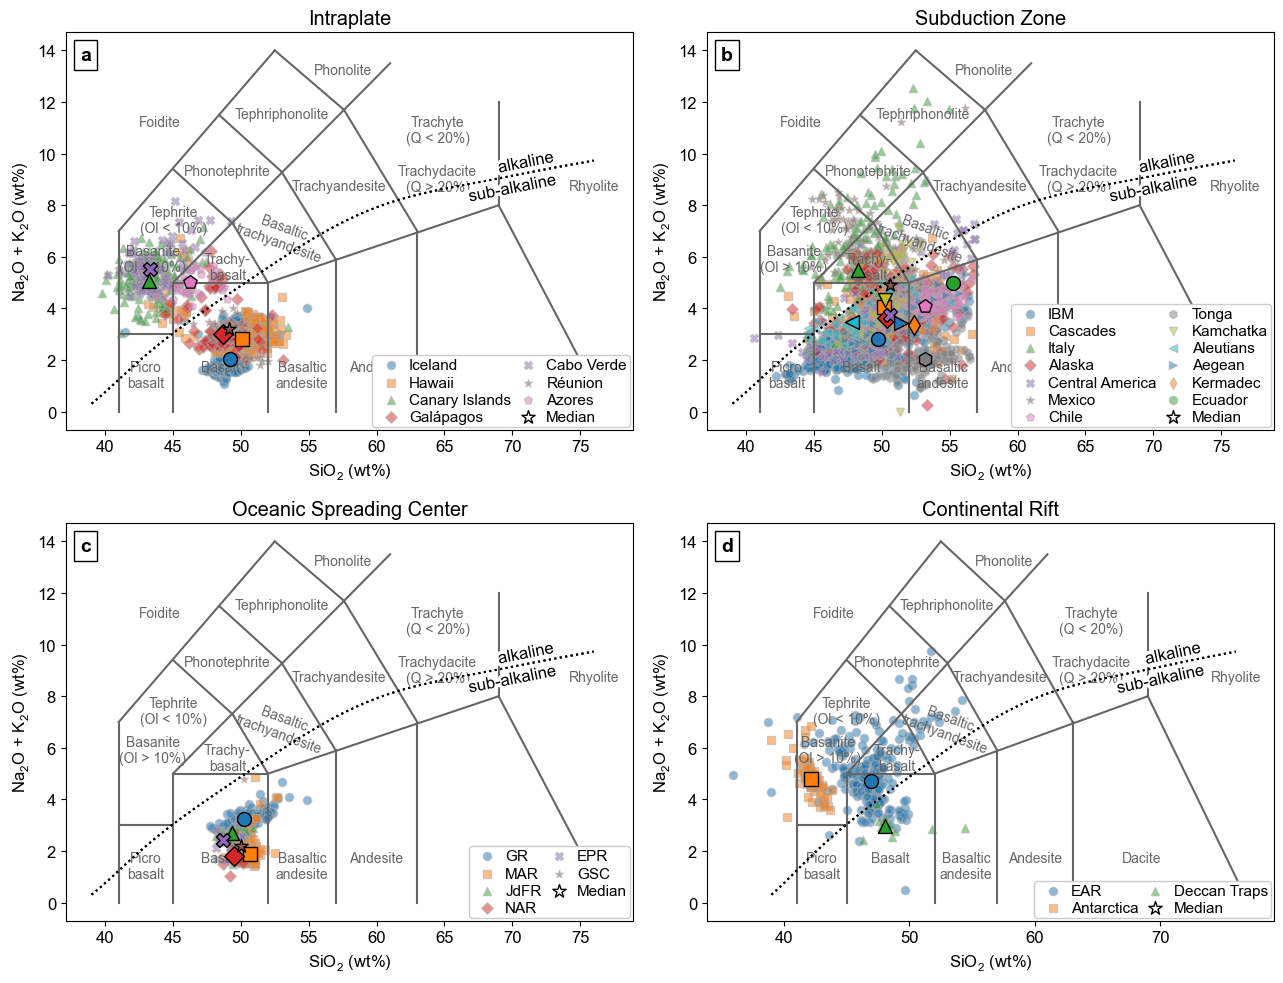

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import tasplot
from labellines import labelLines
import seaborn as sns
import numpy as np

is_oibthol = vdatafilt2['Location type'].str.contains('OIB-Tholeiitic')
is_oib = vdatafilt2['Location type'].str.contains('OIB')
is_oibalk = vdatafilt2['Location type'].str.contains('OIB-Alkalic')
is_intraplate = vdatafilt2['Location type'].str.contains('intraplate')
is_sz = vdatafilt2['Location type'] == 'Subduction Zone'
is_rift = vdatafilt2['Location type'].str.contains('Rift')
is_morb = vdatafilt2['Location type'].str.contains('Ridge')


edgecolors='darkgrey'
alpha=0.5

legend_params = {
    'fontsize': 11,
    'ncols': 2,
    'loc': 'lower right',
    'labelspacing': 0.2,
    'columnspacing': 0.1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'framealpha': 1,
    'borderaxespad': 0.2
}

fig, axs = plt.subplots(2, 2, figsize=(13, 10)) 


sub_data = vdatafilt2[is_oib]
location_counts = sub_data['Location'].value_counts().sort_values(ascending=False)

num_colors_needed = len(location_counts)
new_palette = sns.color_palette("tab10", num_colors_needed)



# Assign colors based on sorted locations using the expanded palette
location_colors = {location: new_palette[i] for i, location in enumerate(location_counts.index)}

medians = sub_data.groupby('Location')[['SiO2', 'Na2O', 'K2O']].median()

markers = ['o', 's', '^', 'D', 'X', '*', 'p', 'h', 'v', '<', '>', 'd']

marker_dict = {location: markers[i % len(markers)] for i, location in enumerate(location_counts.index)}

# Plotting
for location in location_counts.index:
    loc = sub_data['Location'] == location

    axs[0,0].scatter(sub_data['SiO2'][loc], (sub_data['Na2O'][loc] + sub_data['K2O'][loc]), 
                    marker=marker_dict[location], color=location_colors[location], 
                    alpha=alpha, edgecolor=edgecolors, label=location, zorder=-1)

    # Plot median for each location with the same color as the location
    axs[0,0].scatter(medians.loc[location, 'SiO2'], medians.loc[location, 'Na2O'] + medians.loc[location, 'K2O'],
                    color=location_colors[location], edgecolor='k', marker=marker_dict[location], s=100, zorder=3)

# Add a dummy scatter plot for legend
axs[0,0].scatter([], [], edgecolor='k',color='white', marker='*', s=100, label='Median')

axs[0,0].legend(**legend_params)
x_Miya = np.linspace(39, 76, 100)

ex=axs[0,0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='alkaline') 
ex1=axs[0,0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='sub-alkaline') 

labelLines(ex, zorder=3, xvals=[71],yoffsets=0.4, fontsize=12)
labelLines(ex1, zorder=3, xvals=[70],yoffsets=-0.5, fontsize=12,color='k')


############################################
sub_data2 = vdatafilt2[is_sz]
location_counts = sub_data2['Location'].value_counts().sort_values(ascending=False)

num_colors_needed = len(location_counts)
new_palette = sns.color_palette("tab10", num_colors_needed)

# Assign colors based on sorted locations using the expanded palette
location_colors = {location: new_palette[i] for i, location in enumerate(location_counts.index)}
medians = sub_data2.groupby('Location')[['SiO2', 'Na2O', 'K2O']].median()

marker_dict = {location: markers[i % len(markers)] for i, location in enumerate(location_counts.index)}

for location in location_counts.index:
    loc = sub_data2['Location'] == location

    axs[0,1].scatter(sub_data2['SiO2'][loc], (sub_data2['Na2O'][loc] + sub_data2['K2O'][loc]), 
                    marker=marker_dict[location], color=location_colors[location], alpha=alpha, edgecolor=edgecolors, label=location, zorder=-1)

    # Plot median for each location with the same color as the location
    axs[0,1].scatter(medians.loc[location, 'SiO2'], medians.loc[location, 'Na2O'] + medians.loc[location, 'K2O'],
                    color=location_colors[location], edgecolor='k', marker=marker_dict[location], s=100, zorder=3)

# Add a dummy scatter plot for legend
axs[0,1].scatter([], [], edgecolor='k',color='white', marker='*', s=100, label='Median')

axs[0,1].legend(**legend_params)
x_Miya = np.linspace(39, 76, 100)

ex=axs[0,1].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='alkaline') 
ex1=axs[0,1].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='sub-alkaline') 

labelLines(ex, zorder=3, xvals=[71],yoffsets=0.4, fontsize=12)
labelLines(ex1, zorder=3, xvals=[70],yoffsets=-0.5, fontsize=12,color='k')



######################################



sub_data = vdatafilt2[is_morb]
location_counts = sub_data['Location'].value_counts().sort_values(ascending=False)

num_colors_needed = len(location_counts)
new_palette = sns.color_palette("tab10", num_colors_needed)

# Assign colors based on sorted locations using the expanded palette
location_colors = {location: new_palette[i] for i, location in enumerate(location_counts.index)}
medians = sub_data.groupby('Location')[['SiO2', 'Na2O', 'K2O']].median()


marker_dict = {location: markers[i % len(markers)] for i, location in enumerate(location_counts.index)}

for location in location_counts.index:
    loc = sub_data['Location'] == location

    axs[1,0].scatter(sub_data['SiO2'][loc], (sub_data['Na2O'][loc] + sub_data['K2O'][loc]), 
                    marker=marker_dict[location], color=location_colors[location], alpha=alpha, edgecolor=edgecolors, label=location, zorder=-1)

    # Plot median for each location with the same color as the location
    axs[1,0].scatter(medians.loc[location, 'SiO2'], medians.loc[location, 'Na2O'] + medians.loc[location, 'K2O'],
                    color=location_colors[location], edgecolor='k', marker=marker_dict[location], s=100, zorder=3)

# Add a dummy scatter plot for legend
axs[1,0].scatter([], [], edgecolor='k',color='white', marker='*', s=100, label='Median')

legend3=axs[1,0].legend(**legend_params)

x_Miya = np.linspace(39, 76, 100)

ex=axs[1,0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='alkaline') 
ex1=axs[1,0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='sub-alkaline') 

labelLines(ex, zorder=3, xvals=[71],yoffsets=0.4, fontsize=12)
labelLines(ex1, zorder=3, xvals=[70],yoffsets=-0.5, fontsize=12,color='k')


#######################################

sub_data = vdatafilt2[is_rift]
location_counts = sub_data['Location'].value_counts().sort_values(ascending=False)

num_colors_needed = len(location_counts)
new_palette = sns.color_palette("tab10", num_colors_needed)

# Assign colors based on sorted locations using the expanded palette
location_colors = {location: new_palette[i] for i, location in enumerate(location_counts.index)}

medians = sub_data.groupby('Location')[['SiO2', 'Na2O', 'K2O']].median()

marker_dict = {location: markers[i % len(markers)] for i, location in enumerate(location_counts.index)}

for location in location_counts.index:
    loc = sub_data['Location'] == location

    axs[1,1].scatter(sub_data['SiO2'][loc], (sub_data['Na2O'][loc] + sub_data['K2O'][loc]), 
                    marker=marker_dict[location], color=location_colors[location], alpha=alpha, edgecolor=edgecolors, label=location, zorder=-1)

    # Plot median for each location with the same color as the location
    axs[1,1].scatter(medians.loc[location, 'SiO2'], medians.loc[location, 'Na2O'] + medians.loc[location, 'K2O'],
                    color=location_colors[location], edgecolor='k', marker=marker_dict[location], s=100, zorder=3)

# Add a dummy scatter plot for legend
axs[1,1].scatter([], [], edgecolor='k',color='white', marker='*', s=100, label='Median')

axs[1,1].legend(**legend_params)
x_Miya = np.linspace(39, 76, 100)

ex=axs[1,1].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='alkaline') 
ex1=axs[1,1].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='sub-alkaline') 

labelLines(ex, zorder=3, xvals=[71],yoffsets=0.4, fontsize=12)
labelLines(ex1, zorder=3, xvals=[70],yoffsets=-0.5, fontsize=12,color='k')


#############################################
for ax in axs.flat:
    ax.set_xlabel(r'SiO$_2$ (wt%)')  # Use LaTeX notation for subscript
    ax.set_ylabel(r'Na$_2$O + K$_2$O (wt%)')
    tasplot.add_LeMaitre_fields(ax,color=(0.4,0.4,0.4),fontsize=10)  # add TAS fields to plot



axs[0,0].set_title("Intraplate")
axs[0,1].set_title("Subduction Zone")
axs[1,0].set_title("Oceanic Spreading Center")
axs[1,1].set_title("Continental Rift")


pos=(0.025,0.93)

axs[0,0].text(pos[0], pos[1], 'a', transform=axs[0,0].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[0,1].text(pos[0], pos[1], 'b', transform=axs[0,1].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[1,0].text(pos[0], pos[1], 'c', transform=axs[1,0].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[1,1].text(pos[0], pos[1], 'd', transform=axs[1,1].transAxes, fontsize=14, fontweight='bold', bbox=bbox)




plt.tight_layout()
plt.show()


fig.savefig( "FigS_TASplot_all.pdf")


## Plot the TAS for OIBs next to P-XH2O

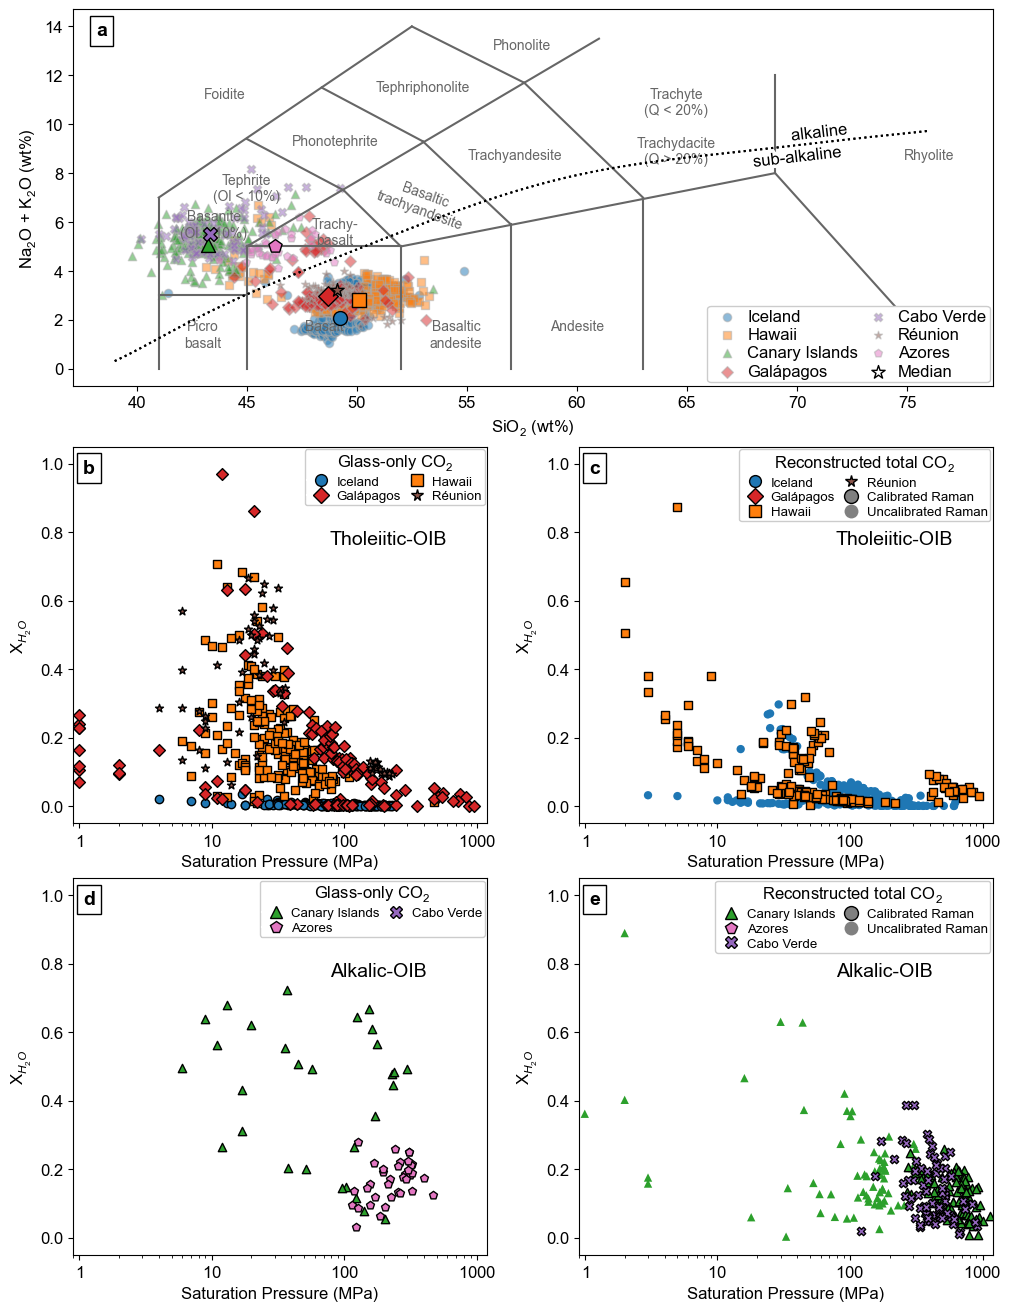

In [61]:
from matplotlib.ticker import ScalarFormatter
plotting_df=vdatafilt2.copy()#data_filtered_P_over20.copy()

is_oibthol = plotting_df['Location type'].str.contains('OIB-Tholeiitic')
is_oib = plotting_df['Location type'].str.contains('OIB')
is_oibalk = plotting_df['Location type'].str.contains('OIB-Alkalic')
is_intraplate = plotting_df['Location type'].str.contains('intraplate')
is_sz = plotting_df['Location type'] == 'Subduction Zone'
is_rift = plotting_df['Location type'].str.contains('Rift')
is_morb = plotting_df['Location type'].str.contains('Ridge')


edgecolors='darkgrey'
alpha=0.5

legend_params = {
    'fontsize': 12,
    'ncols': 2,
    'loc': 'lower right',
    'labelspacing': 0.2,
    'columnspacing': 0.2,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'framealpha': 1,
    'borderaxespad': 0.2
}

legend_params_subplot = legend_params.copy()
legend_params_subplot['loc'] = 'upper right'
legend_params_subplot['fontsize'] = 9.5

# fig, axs = plt.subplots(3, 1, figsize=(7, 15)) 
mosaic_layout = [
    [0,0],         # Top panel spans across two columns
    [1,3],  # First row of the bottom grid
    [2,4]   # Second row of the bottom grid
]

# Create the figure and axes using the mosaic layout
fig, axs = plt.subplot_mosaic(mosaic_layout, figsize=(10, 13), constrained_layout=True)

sub_data = plotting_df[is_oib]
location_counts = sub_data['Location'].value_counts().sort_values(ascending=False)

num_colors_needed = len(location_counts)
new_palette = sns.color_palette("tab10", num_colors_needed)


# Assign colors based on sorted locations using the expanded palette
location_colors = {location: new_palette[i] for i, location in enumerate(location_counts.index)}

medians = sub_data.groupby('Location')[['SiO2', 'Na2O', 'K2O']].median()

markers = ['o', 's', '^', 'D', 'X', '*', 'p', 'h', 'v', '<', '>', 'd']

marker_dict = {location: markers[i % len(markers)] for i, location in enumerate(location_counts.index)}

# Plotting
for location in location_counts.index:
    loc = sub_data['Location'] == location

    axs[0].scatter(sub_data['SiO2'][loc], (sub_data['Na2O'][loc] + sub_data['K2O'][loc]), 
                    marker=marker_dict[location], color=location_colors[location], 
                    alpha=alpha, edgecolor=edgecolors, label=location, zorder=-1)

    # Plot median for each location with the same color as the location
    axs[0].scatter(medians.loc[location, 'SiO2'], medians.loc[location, 'Na2O'] + medians.loc[location, 'K2O'],
                    color=location_colors[location], edgecolor='k', marker=marker_dict[location], s=100, zorder=3)

# Add a dummy scatter plot for legend
axs[0].scatter([], [], edgecolor='k',color='white', marker='*', s=100, label='Median')

axs[0].legend(**legend_params)
x_Miya = np.linspace(39, 76, 100)

ex=axs[0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='alkaline') 
ex1=axs[0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='sub-alkaline') 

labelLines(ex, zorder=3, xvals=[71],yoffsets=0.4, fontsize=12)
labelLines(ex1, zorder=3, xvals=[70],yoffsets=-0.5, fontsize=12,color='k')



axs[0].set_xlabel(r'SiO$_2$ (wt%)')  # Use LaTeX notation for subscript
axs[0].set_ylabel(r'Na$_2$O + K$_2$O (wt%)')
tasplot.add_LeMaitre_fields(axs[0],color=(0.4,0.4,0.4),fontsize=10)  # add TAS fields to plot


pos=(0.025,0.93)

axs[0].text(pos[0], pos[1], 'a', transform=axs[0].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[1].text(pos[0], pos[1], 'b', transform=axs[1].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[2].text(pos[0], pos[1], 'd', transform=axs[2].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[3].text(pos[0], pos[1], 'c', transform=axs[3].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[4].text(pos[0], pos[1], 'e', transform=axs[4].transAxes, fontsize=14, fontweight='bold', bbox=bbox)

plotting_df.loc[:, 'Raman/Homog'] = plotting_df['Raman/Homog'].fillna('')

siO2_min_all, siO2_max_all = plotting_df['SiO2'].min(), plotting_df['SiO2'].max()
satP_min_all, satP_max_all = plotting_df['SaturationP_bars_VESIcal'].min(), plotting_df['SaturationP_bars_VESIcal'].max()

kbar_or_MPa=10

# Set colormap
siO2_colormap = plt.get_cmap('cividis')

x_col, y_col = 'SaturationP_bars_VESIcal', 'XH2O_fl_VESIcal'

for i, location_type in enumerate([is_oibthol, is_oibalk]):
    loc_data = plotting_df[location_type]
    glass_only_data = loc_data[~loc_data['Raman/Homog'].str.contains('Raman')]
    raman_cal_data = loc_data[loc_data['Raman/Homog'].str.contains('Raman-cal')]
    raman_uncal_data = loc_data[loc_data['Raman/Homog'].str.contains('Raman-uncal')]

    # Filter locations based on presence in each subplot
    locations_in_subplot = set(glass_only_data['Location']) | set(raman_cal_data['Location']) | set(raman_uncal_data['Location'])

    # Plot only if the location is present in the current subplot
    for location in location_counts.index:
        if location in locations_in_subplot:
            loc = loc_data['Location'] == location

            axs[i+1].scatter(glass_only_data[x_col][loc]/kbar_or_MPa, glass_only_data[y_col][loc], 
                            marker=marker_dict[location], color=location_colors[location], 
                            alpha=1, edgecolor='k',label='_nolegend_', zorder=0)
            axs[i+3].scatter(raman_uncal_data[x_col][loc]/kbar_or_MPa, raman_uncal_data[y_col][loc], 
                            marker=marker_dict[location], color=location_colors[location], 
                            alpha=1, edgecolor='none', label='_nolegend_', zorder=1)
            axs[i+3].scatter(raman_cal_data[x_col][loc]/kbar_or_MPa, raman_cal_data[y_col][loc], 
                            marker=marker_dict[location], color=location_colors[location], 
                            alpha=1, edgecolor='k', label='_nolegend_', zorder=2)

    # Create legend handles and labels
    legend_handles = []
    legend_labels = []
    for location in locations_in_subplot:
        legend_handles.append(plt.Line2D([0], [0], marker=marker_dict[location], markeredgecolor='k',color='w', markerfacecolor=location_colors[location], markersize=8.5))
        legend_labels.append(location)

    # Add legend for current subplot
    axs[i+1].legend(legend_handles, legend_labels, **legend_params_subplot,title='Glass-only CO$_2$')

    # Add marker legends
    legend_handles.extend([
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='k', markersize=10, linestyle=''),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markeredgecolor='none', markersize=10, linestyle='')
    ])
    legend_labels.extend(['Calibrated Raman', 'Uncalibrated Raman'])
    axs[i+3].legend(legend_handles, legend_labels, **legend_params_subplot,title='Reconstructed total CO$_2$')

pos=(0.62,0.74)
axs[1].text(pos[0], pos[1], 'Tholeiitic-OIB', transform=axs[1].transAxes, fontsize=14, fontweight='regular')
axs[2].text(pos[0], pos[1], 'Alkalic-OIB', transform=axs[2].transAxes, fontsize=14, fontweight='regular')
axs[3].text(pos[0], pos[1], 'Tholeiitic-OIB', transform=axs[3].transAxes, fontsize=14, fontweight='regular')
axs[4].text(pos[0], pos[1], 'Alkalic-OIB', transform=axs[4].transAxes, fontsize=14, fontweight='regular')

for i in [1,2,3,4]:
    axs[i].set_xlabel("Saturation Pressure (MPa)")
    axs[i].set_ylabel("X$_{H_2O}$")
    # axs[i].set_xlim([-300/kbar_or_MPa,12000/kbar_or_MPa])
    axs[i].set_ylim([-0.05,1.05])
    axs[i].set_xscale("log")
    axs[i].set_xlim([0.9,1200])
    axs[i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))


plt.show()


fig.savefig("FigS_TASplot+XH2OvsP.pdf")

## Version coloured by SiO2

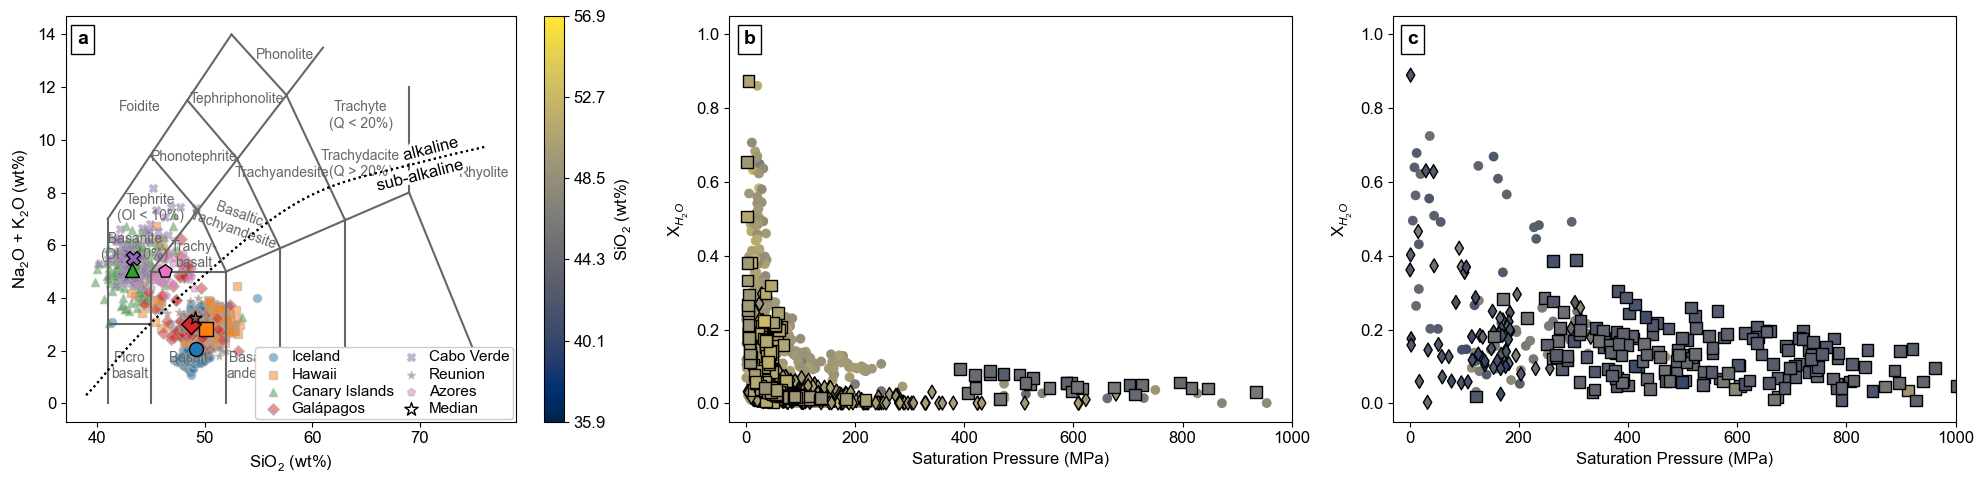

In [49]:
is_oibthol = vdatafilt2['Location type'].str.contains('OIB-Tholeiitic')
is_oib = vdatafilt2['Location type'].str.contains('OIB')
is_oibalk = vdatafilt2['Location type'].str.contains('OIB-Alkalic')
is_intraplate = vdatafilt2['Location type'].str.contains('intraplate')
is_sz = vdatafilt2['Location type'] == 'Subduction Zone'
is_rift = vdatafilt2['Location type'].str.contains('Rift')
is_morb = vdatafilt2['Location type'].str.contains('Ridge')


edgecolors='darkgrey'
alpha=0.5

legend_params = {
    'fontsize': 11,
    'ncols': 2,
    'loc': 'lower right',
    'labelspacing': 0.2,
    'columnspacing': 0.1,
    'borderpad': 0.2,
    'handletextpad': 0.2,
    'framealpha': 1,
    'borderaxespad': 0.2
}

fig, axs = plt.subplots(1, 3, figsize=(20, 5)) 


sub_data = vdatafilt2[is_oib]
location_counts = sub_data['Location'].value_counts().sort_values(ascending=False)

num_colors_needed = len(location_counts)
new_palette = sns.color_palette("tab10", num_colors_needed)


# Assign colors based on sorted locations using the expanded palette
location_colors = {location: new_palette[i] for i, location in enumerate(location_counts.index)}

medians = sub_data.groupby('Location')[['SiO2', 'Na2O', 'K2O']].median()

markers = ['o', 's', '^', 'D', 'X', '*', 'p', 'h', 'v', '<', '>', 'd']

marker_dict = {location: markers[i % len(markers)] for i, location in enumerate(location_counts.index)}

# Plotting
for location in location_counts.index:
    loc = sub_data['Location'] == location

    axs[0].scatter(sub_data['SiO2'][loc], (sub_data['Na2O'][loc] + sub_data['K2O'][loc]), 
                    marker=marker_dict[location], color=location_colors[location], 
                    alpha=alpha, edgecolor=edgecolors, label=location, zorder=-1)

    # Plot median for each location with the same color as the location
    axs[0].scatter(medians.loc[location, 'SiO2'], medians.loc[location, 'Na2O'] + medians.loc[location, 'K2O'],
                    color=location_colors[location], edgecolor='k', marker=marker_dict[location], s=100, zorder=3)

# Add a dummy scatter plot for legend
axs[0].scatter([], [], edgecolor='k',color='white', marker='*', s=100, label='Median')

axs[0].legend(**legend_params)
x_Miya = np.linspace(39, 76, 100)

ex=axs[0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='alkaline') 
ex1=axs[0].plot(x_Miya,Miya_Pf(x_Miya),color='k',linestyle=':',label='sub-alkaline') 

labelLines(ex, zorder=3, xvals=[71],yoffsets=0.4, fontsize=12)
labelLines(ex1, zorder=3, xvals=[70],yoffsets=-0.5, fontsize=12,color='k')



axs[0].set_xlabel(r'SiO$_2$ (wt%)')  # Use LaTeX notation for subscript
axs[0].set_ylabel(r'Na$_2$O + K$_2$O (wt%)')
tasplot.add_LeMaitre_fields(axs[0],color=(0.4,0.4,0.4),fontsize=10)  # add TAS fields to plot


pos=(0.025,0.93)

axs[0].text(pos[0], pos[1], 'a', transform=axs[0].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[1].text(pos[0], pos[1], 'b', transform=axs[1].transAxes, fontsize=14, fontweight='bold', bbox=bbox)
axs[2].text(pos[0], pos[1], 'c', transform=axs[2].transAxes, fontsize=14, fontweight='bold', bbox=bbox)


vdatafilt2.loc[:, 'Raman/Homog'] = vdatafilt2['Raman/Homog'].fillna('')

siO2_min_all, siO2_max_all = vdatafilt2['SiO2'].min(), vdatafilt2['SiO2'].max()
satP_min_all, satP_max_all = vdatafilt2['SaturationP_bars_VESIcal'].min(), vdatafilt2['SaturationP_bars_VESIcal'].max()

kbar_or_MPa=10

# Set colormap
siO2_colormap = plt.get_cmap('cividis')

x_col, y_col = 'SaturationP_bars_VESIcal', 'XH2O_fl_VESIcal'

loc_data = vdatafilt2[is_oibthol]
glass_only_data = loc_data[~loc_data['Raman/Homog'].str.contains('Raman')]
raman_cal_data = loc_data[loc_data['Raman/Homog'].str.contains('Raman-cal')]
raman_uncal_data = loc_data[loc_data['Raman/Homog'].str.contains('Raman-uncal')]
axs[1].scatter(glass_only_data[x_col]/kbar_or_MPa, glass_only_data[y_col], c=glass_only_data['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all, edgecolor='none', s=50, label='Glass-only', marker='o')
axs[1].scatter(raman_uncal_data[x_col]/kbar_or_MPa, raman_uncal_data[y_col], c=raman_uncal_data['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all, edgecolor='k', s=50, label='Raman-uncalibrated', marker='d')
axs[1].scatter(raman_cal_data[x_col]/kbar_or_MPa, raman_cal_data[y_col], c=raman_cal_data['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all, edgecolor='k', s=70, label='Raman-calibrated', marker='s')

loc_data = vdatafilt2[is_oibalk]
glass_only_data = loc_data[~loc_data['Raman/Homog'].str.contains('Raman')]
raman_cal_data = loc_data[loc_data['Raman/Homog'].str.contains('Raman-cal')]
raman_uncal_data = loc_data[loc_data['Raman/Homog'].str.contains('Raman-uncal')]
axs[2].scatter(glass_only_data[x_col]/kbar_or_MPa, glass_only_data[y_col], c=glass_only_data['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all, edgecolor='none', s=50, label='Glass-only', marker='o')
axs[2].scatter(raman_uncal_data[x_col]/kbar_or_MPa, raman_uncal_data[y_col], c=raman_uncal_data['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all, edgecolor='k', s=50, label='Raman-uncalibrated', marker='d')
axs[2].scatter(raman_cal_data[x_col]/kbar_or_MPa, raman_cal_data[y_col], c=raman_cal_data['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all, edgecolor='k', s=70, label='Raman-calibrated', marker='s')

for i in [1,2]:
    axs[i].set_xlabel("Saturation Pressure (MPa)")
    axs[i].set_ylabel("X$_{H_2O}$")
    axs[i].set_xlim([-300/kbar_or_MPa,10000/kbar_or_MPa])
    axs[i].set_ylim([-0.05,1.05])
    
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=siO2_colormap), ax=axs[0], label='SiO$_2$ (wt%)')
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.ax.set_yticklabels(np.round(np.linspace(siO2_min_all, siO2_max_all, 6), 1))

plt.tight_layout()
plt.show()



fig.savefig("FigS_TASplot+XH2OvsP.pdf")


In [50]:
data_4loopplot=vdatafilt.copy()
data_4loopplot.loc[:, 'Raman/Homog'] = data_4loopplot['Raman/Homog'].fillna('')

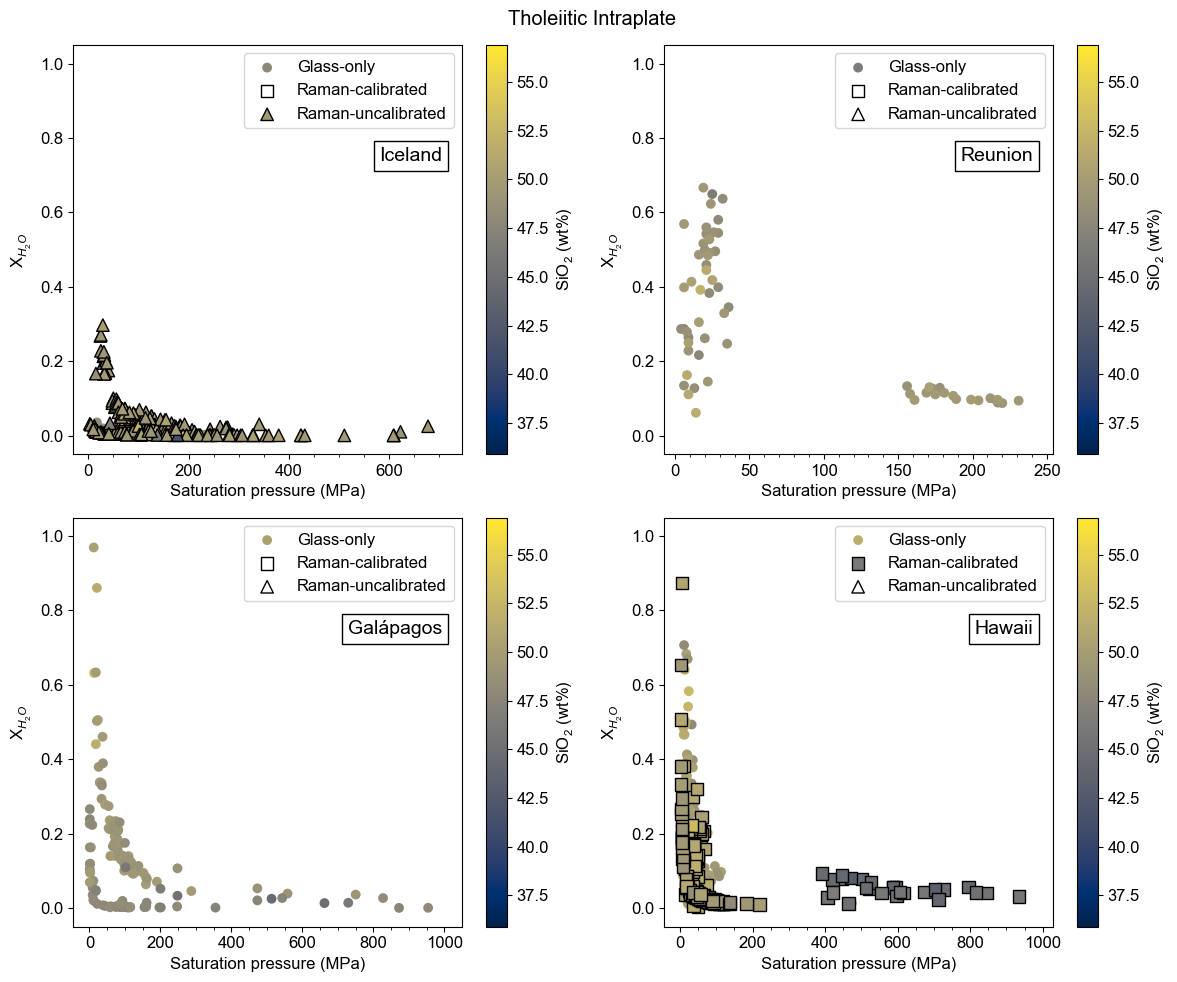

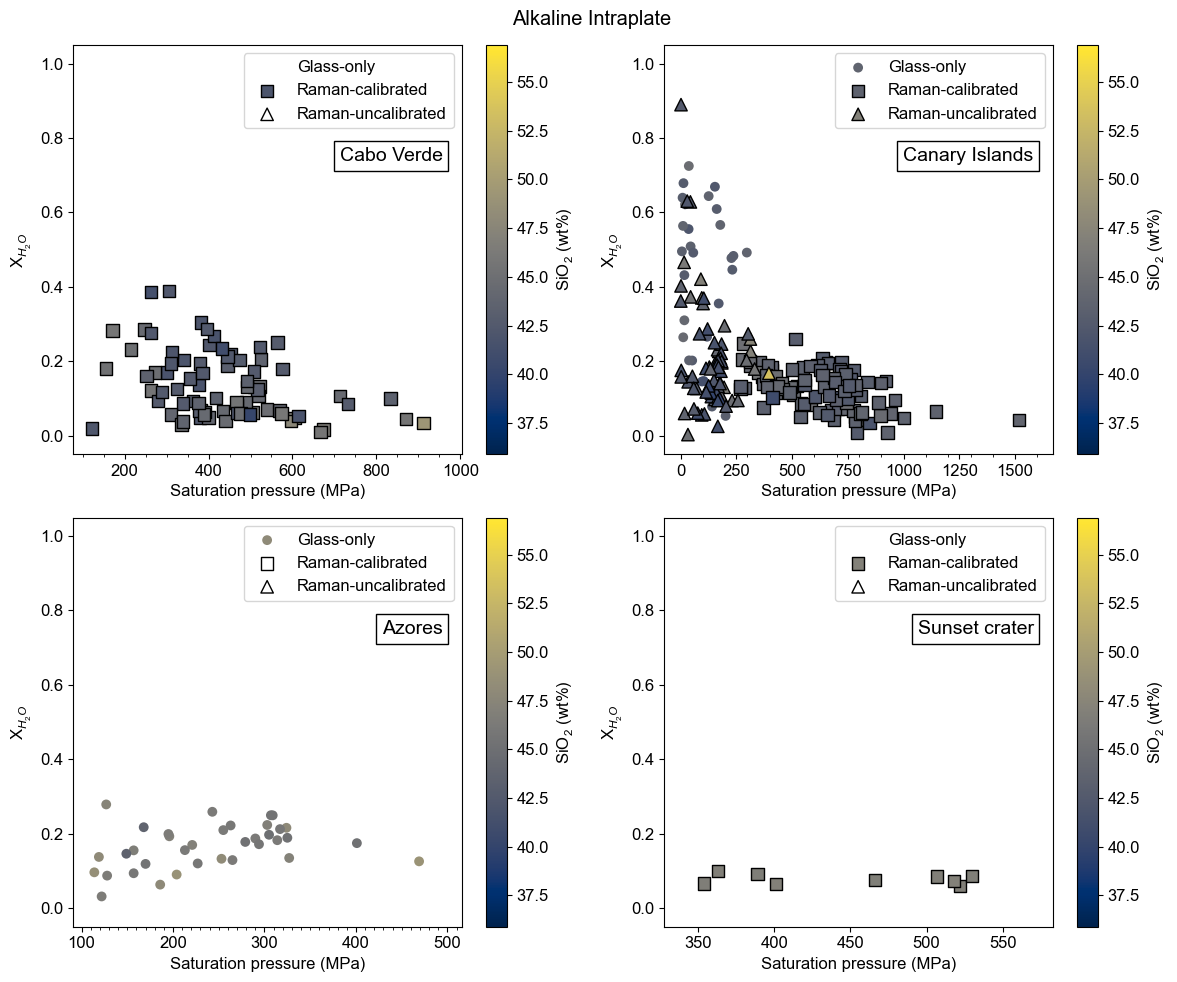

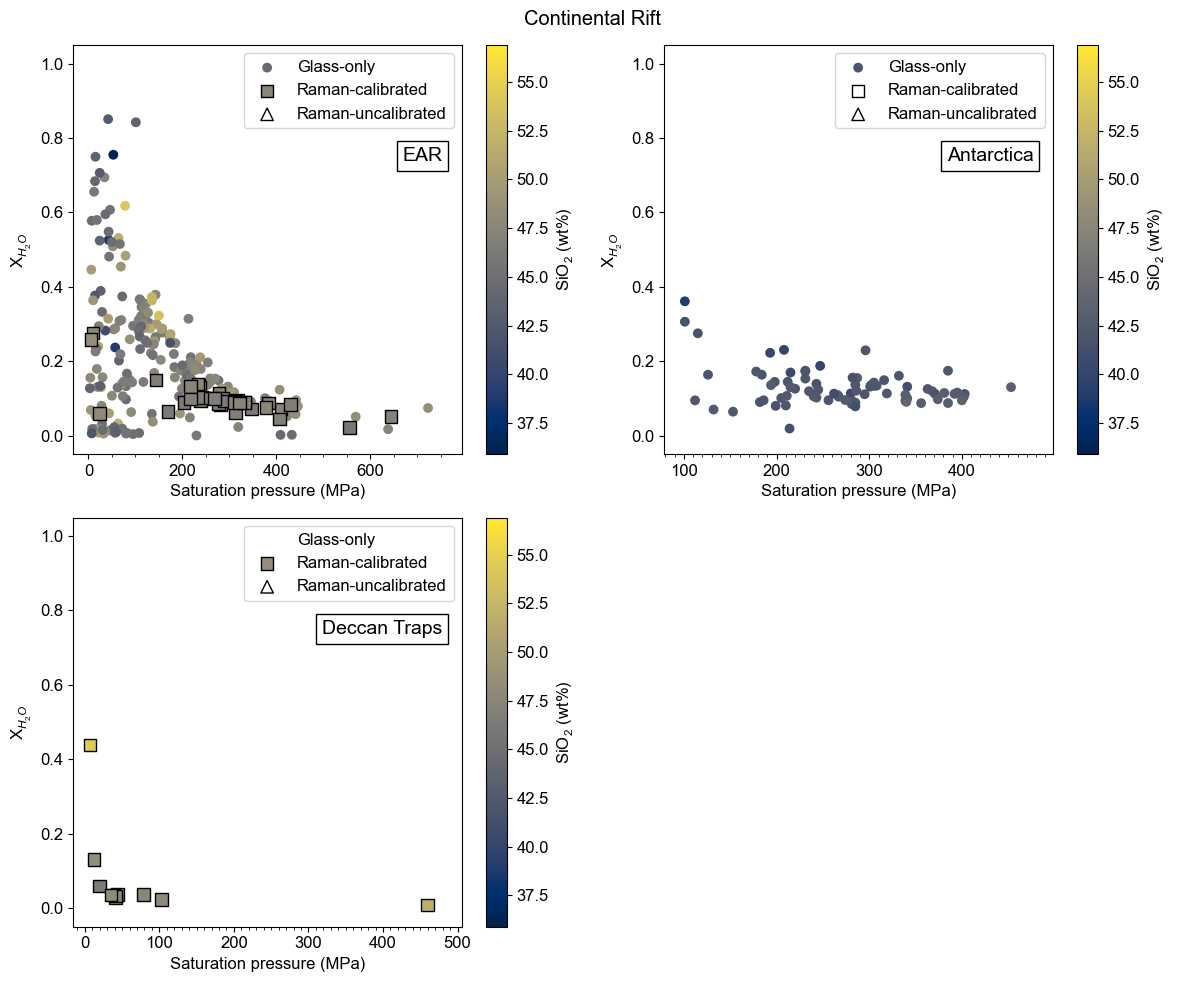

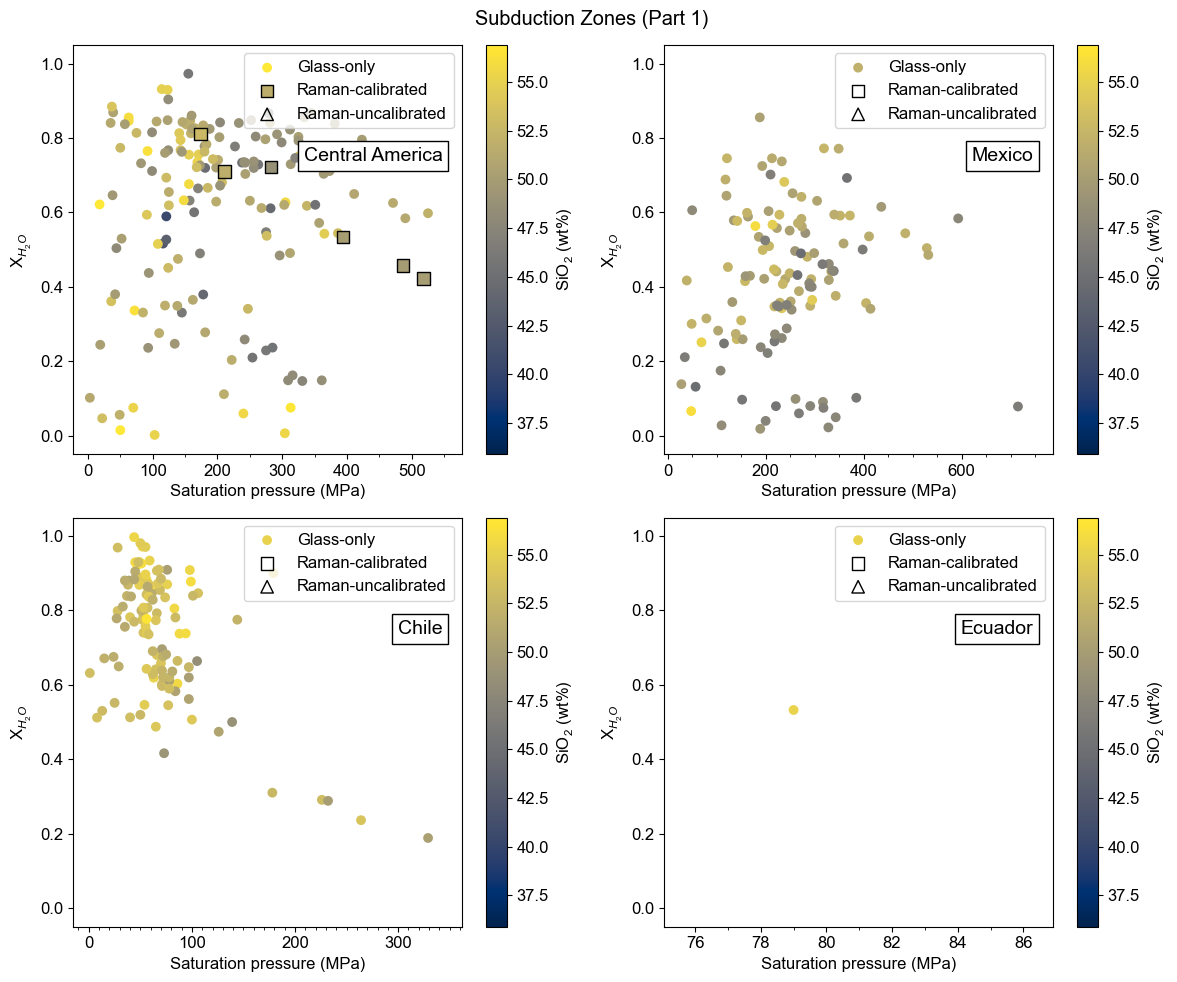

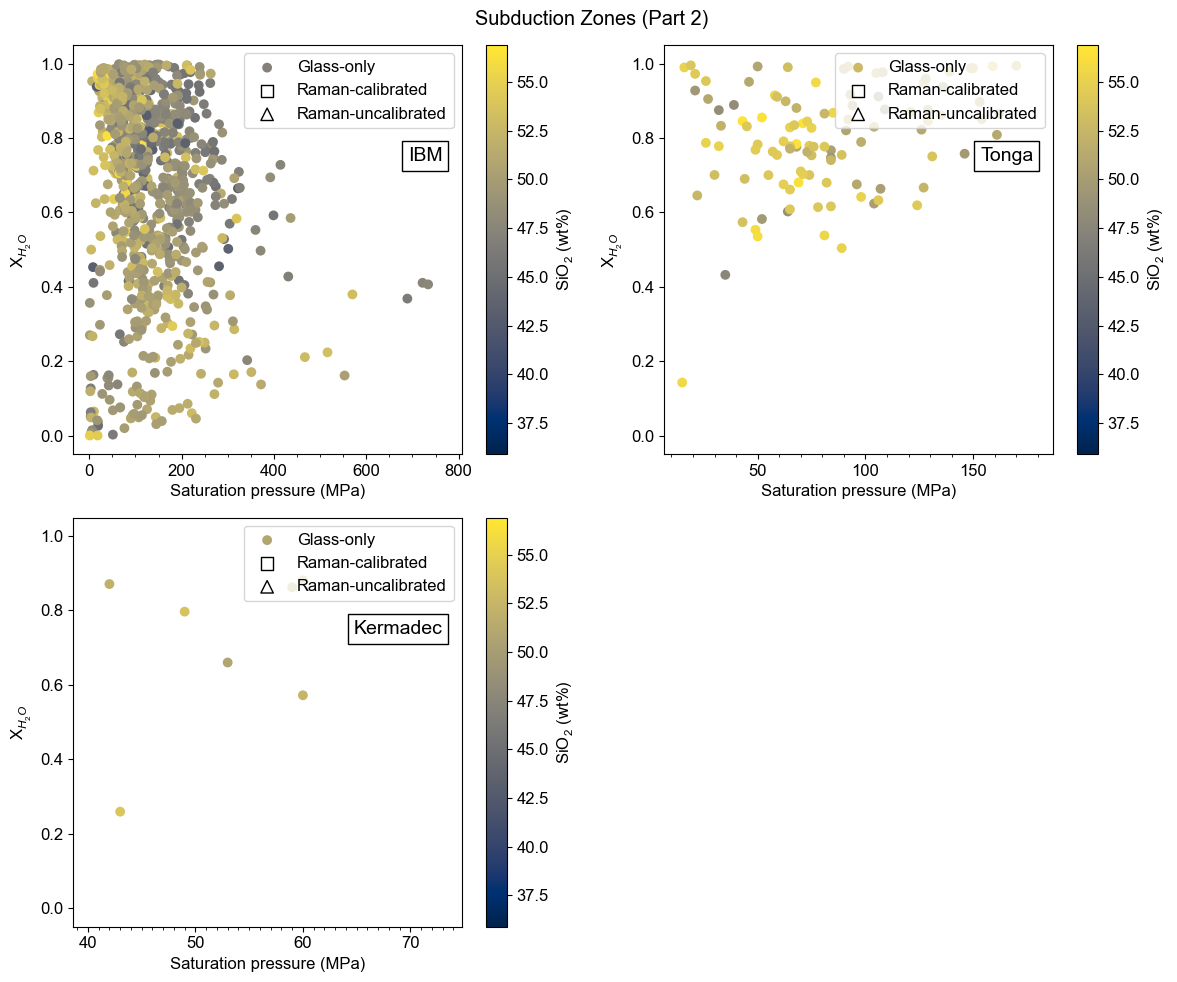

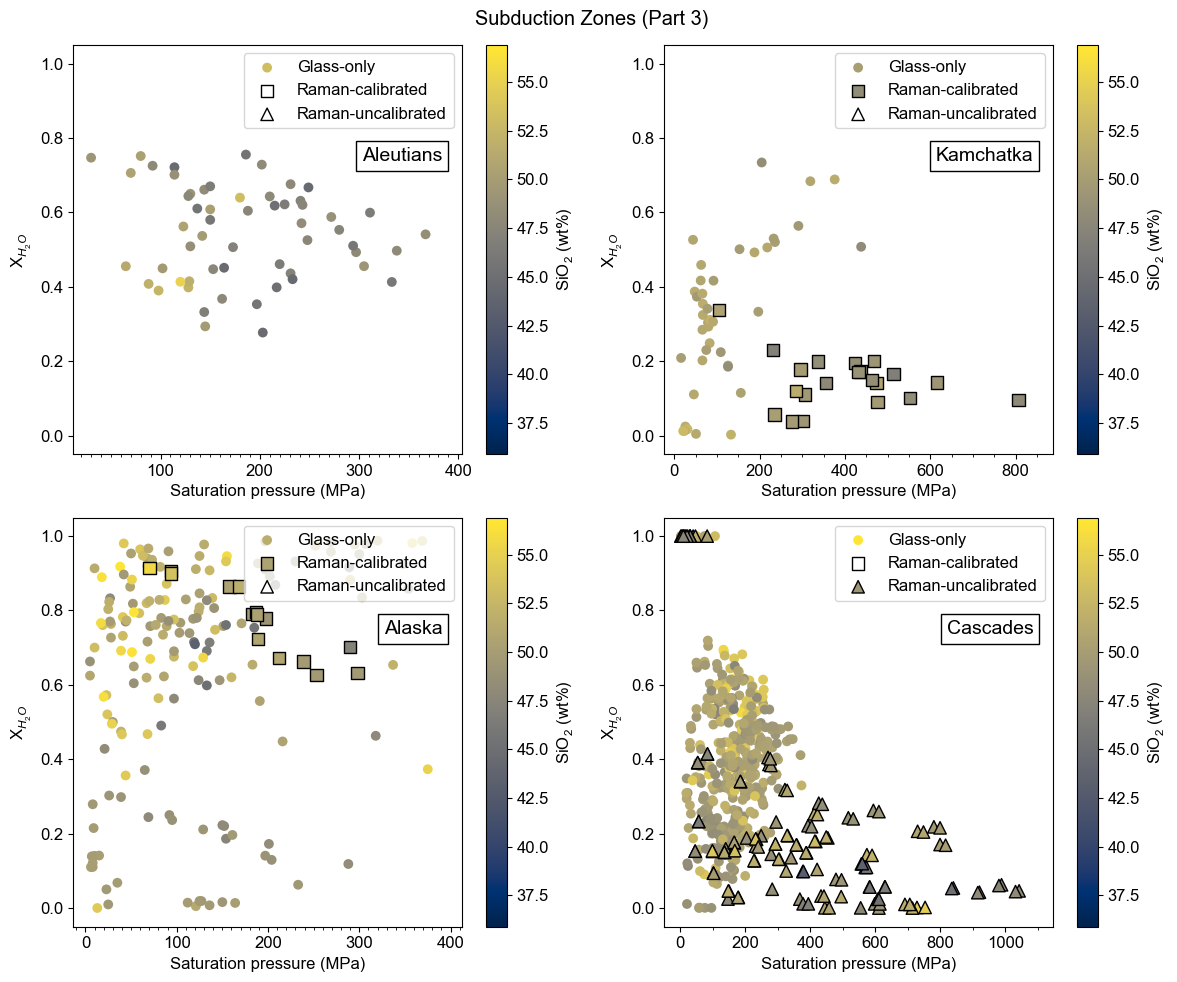

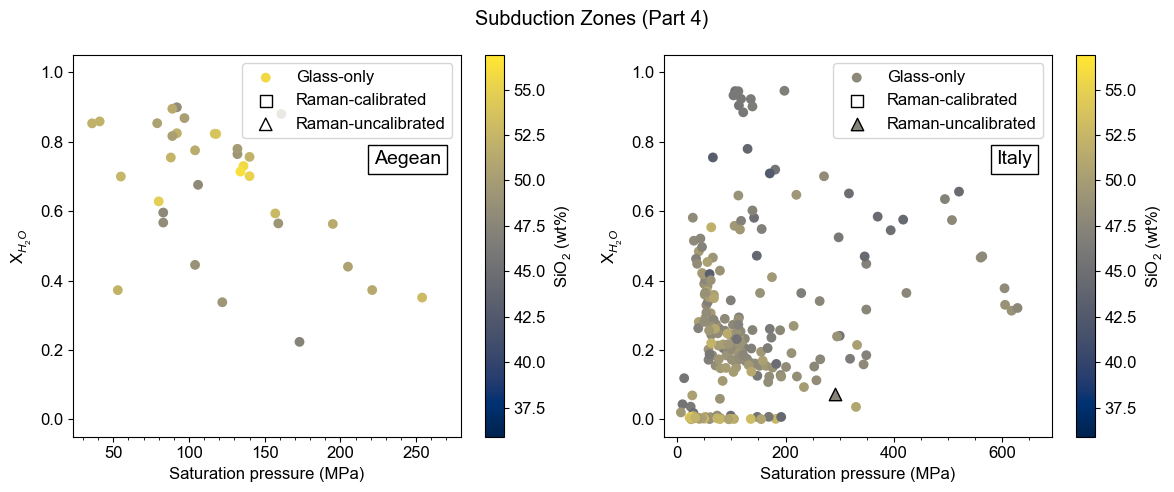

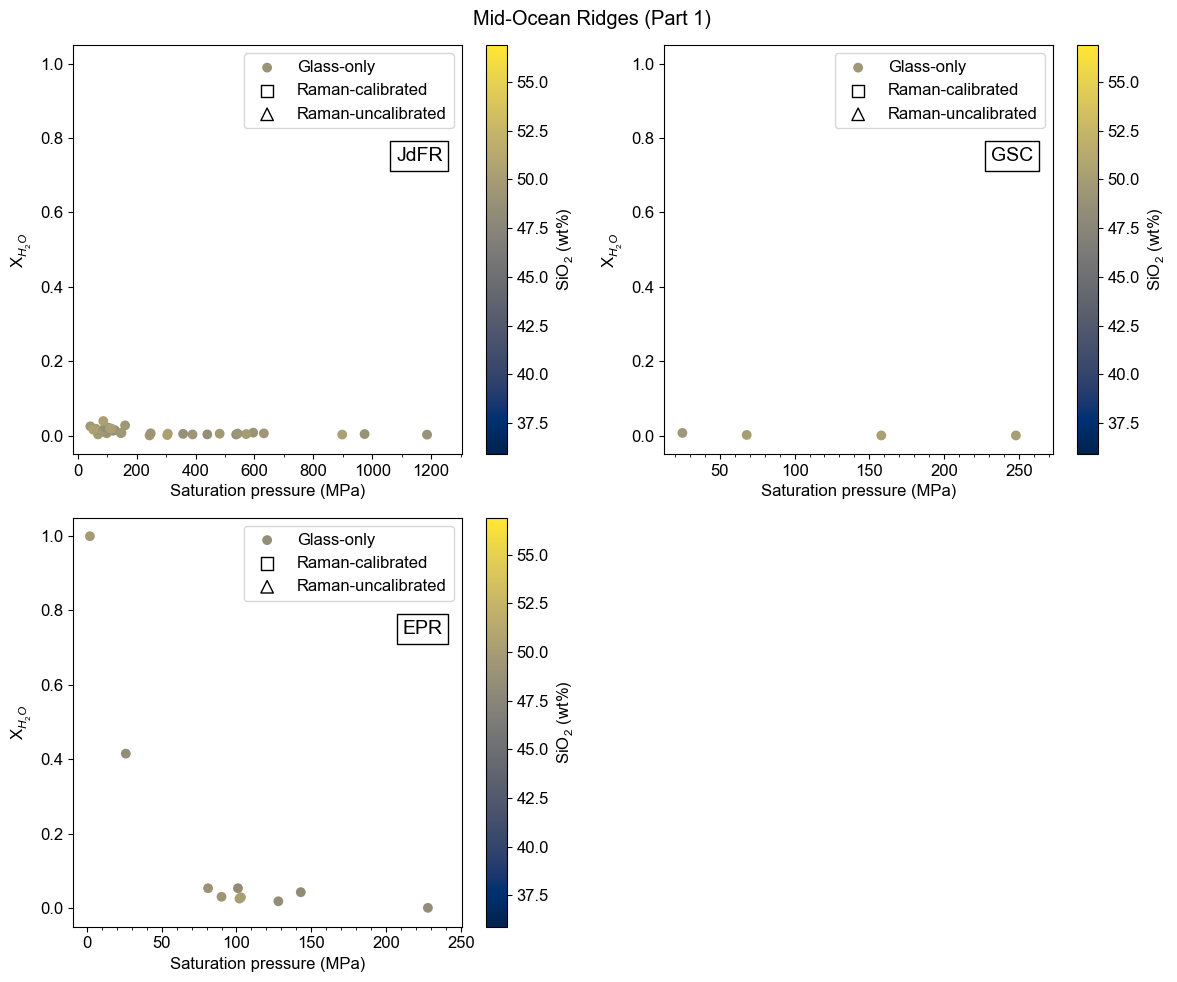

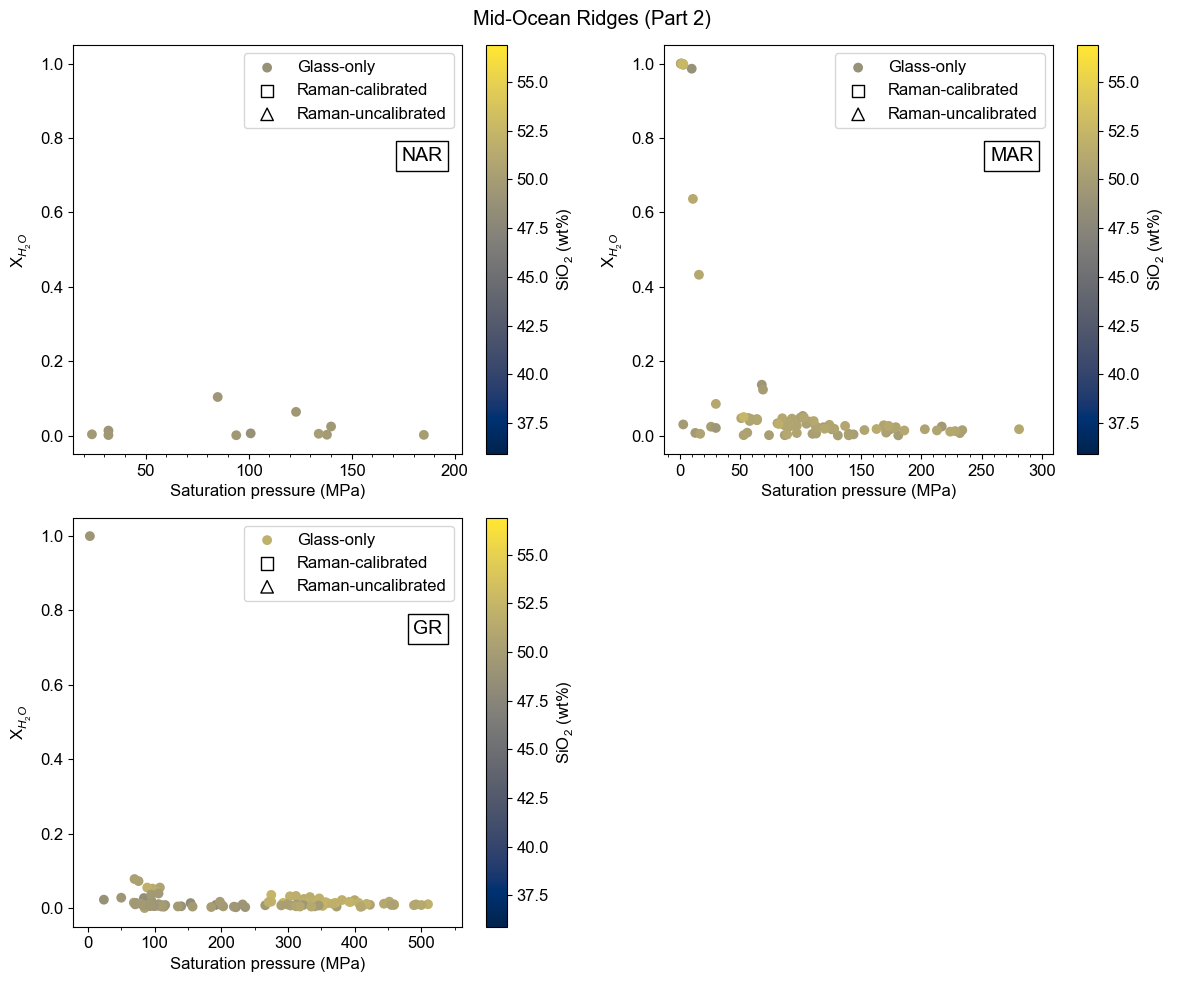

In [51]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

bbox=dict(boxstyle='square', facecolor='white', edgecolor='black')

siO2_min_all = data_4loopplot['SiO2'].min()
siO2_max_all = data_4loopplot['SiO2'].max()

# Convert saturation pressure from bars to MPa
satP_min_all = data_4loopplot['SaturationP_bars_VESIcal'].min() / 10
satP_max_all = data_4loopplot['SaturationP_bars_VESIcal'].max() / 10

siO2_colormap = plt.get_cmap('cividis')

x_col = 'SaturationP_bars_VESIcal'
y_col = 'XH2O_fl_VESIcal'

# Lists of 'Location type'
locations_lists = [
    ['Iceland', 'Reunion', 'Galápagos', 'Hawaii'],
    ['Cabo Verde', 'Canary Islands', 'Azores', 'Sunset crater'],
    ['EAR', 'Antarctica', 'Deccan Traps'],
    ['Central America', 'Mexico', 'Chile', 'Ecuador'],
    ['IBM', 'Tonga', 'Kermadec'],
    ['Aleutians', 'Kamchatka', 'Alaska', 'Cascades'],
    ['Aegean', 'Italy'],
    ['JdFR', 'GSC', 'EPR'],
    ['NAR', 'MAR', 'GR']
]
loctype_lists = [
    'Tholeiitic Intraplate',
    'Alkaline Intraplate',
    'Continental Rift',
    'Subduction Zones (Part 1)',
    'Subduction Zones (Part 2)',
    'Subduction Zones (Part 3)',
    'Subduction Zones (Part 4)',
    'Mid-Ocean Ridges (Part 1)',
    'Mid-Ocean Ridges (Part 2)'
]

# Determine the number of rows needed for subplot arrangement for each location list
num_cols = 2
num_rows = [((len(locations) + num_cols - 1) // num_cols) for locations in locations_lists]

# Create subplots for each location list
for locations, num_row, loc_type in zip(locations_lists, num_rows, loctype_lists):
    fig, axs = plt.subplots(num_row, num_cols, figsize=(6*num_cols, 5*num_row))  # 5 columns

    # Flatten the axs array if there's only one row
    if num_row == 1:
        axs = axs.reshape(1, -1)

    for i, location in enumerate(locations):
        row_index = i // num_cols
        col_index = i % num_cols

        glassonly = data_4loopplot[(data_4loopplot['Location'] == location) & ~(data_4loopplot['Raman/Homog'].str.contains('Raman|Homog'))]
        ramancal = data_4loopplot[(data_4loopplot['Location'] == location) & (data_4loopplot['Raman/Homog'].str.contains('Raman-cal'))]
        ramanuncal = data_4loopplot[(data_4loopplot['Location'] == location) & (data_4loopplot['Raman/Homog'].str.contains('Raman-uncal'))]

        scatter_glassonly = axs[row_index, col_index].scatter(glassonly[x_col] / 10, glassonly[y_col],
                                                              c=glassonly['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                              edgecolor='none', s=50, label='Glass-only', marker='o')

        scatter_ramancal = axs[row_index, col_index].scatter(ramancal[x_col] / 10, ramancal[y_col],
                                                              c=ramancal['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                              edgecolor='k', s=80, label='Raman-calibrated', marker='s')

        scatter_ramanuncal = axs[row_index, col_index].scatter(ramanuncal[x_col] / 10, ramanuncal[y_col],
                                                                c=ramanuncal['SiO2'], cmap=siO2_colormap, vmin=siO2_min_all, vmax=siO2_max_all,
                                                                edgecolor='k', s=80, label='Raman-uncalibrated', marker='^')

        max_x=max(data_4loopplot[(data_4loopplot['Location'] == location)][x_col])/10
        min_x=min(data_4loopplot[(data_4loopplot['Location'] == location)][x_col])/10
        # Add annotation
        axs[row_index, col_index].annotate(location, xy=(0.95, 0.75), xycoords='axes fraction', fontsize=14,
                                           ha='right', va='top', bbox=bbox,transform=axs[row_index,col_index].transAxes)

        axs[row_index, col_index].set_xlabel('Saturation pressure (MPa)')  # Update x-axis label
        axs[row_index, col_index].set_ylabel('X$_{H_2O}$')

        axs[row_index, col_index].legend(loc='upper right')
        axs[row_index, col_index].set_ylim([-0.05, 1.05])
        axs[row_index, col_index].set_xlim([min_x-0.05*max_x, max_x+0.1*max_x])  # Update x-axis limit


        if max_x < 100:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(1))
        elif 100 <= max_x < 500:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(10))
        elif 500 <= max_x < 1000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(50))
        elif 1000 <= max_x < 5000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(100))
        elif max_x>=5000:
            axs[row_index, col_index].xaxis.set_minor_locator(MultipleLocator(500))


        # Add color bar
        cbar_glassonly = fig.colorbar(scatter_glassonly, ax=axs[row_index, col_index])
        cbar_glassonly.set_label('SiO$_2$ (wt%)')
    
    fig.suptitle(loc_type)
    # Hide any extra empty subplots
    for i in range(len(locations), num_row * num_cols):
        row_index = i // num_cols
        col_index = i % num_cols
        axs[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig('FigS_Loop_'+str(loc_type)+'.pdf')
